In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression, Lars, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, accuracy_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
import joblib
import seaborn as sns
from scipy.stats import ttest_rel
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests

# another way of ignoring warnings
warnings.filterwarnings('ignore')

# Loading data

In [2]:
### Importing data
df = pd.read_csv("case1Data.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
df.head(10)

,y,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,...,x_91,x_92,x_93,x_94,x_95,C_01,C_02,C_03,C_04,C_05
0,375.823073,6.359019,-13.367120,-2.483750,-6.641891,11.733539,NaN,-17.085361,22.194764,16.827888,...,-10.200888,3.980048,-4.433274,-1.473723,NaN,74.0,72.0,72.0,73.0,73.0
1,266.811730,3.873664,-8.470389,-3.055012,NaN,11.420983,1.822330,-13.694100,22.738654,20.307503,...,-9.740207,NaN,-2.629314,4.816987,-12.240248,74.0,72.0,72.0,73.0,73.0
2,267.271759,5.275824,-12.070531,-1.366168,-4.819100,10.721527,-5.125992,-17.476865,NaN,15.963889,...,-14.501970,10.054005,NaN,NaN,-11.107921,73.0,72.0,75.0,74.0,74.0
3,219.951294,4.430110,-4.467975,-0.730736,-10.047104,11.498539,-2.870260,-14.033012,18.225190,10.409488,...,-11.086963,2.019726,-8.531959,3.520833,NaN,71.0,72.0,73.0,71.0,72.0
4,289.697954,3.116458,-8.518713,-6.796050,NaN,7.646285,-3.118309,-13.102567,22.801217,16.680208,...,-9.117422,6.627601,-2.805531,5.914351,-11.240573,72.0,72.0,72.0,74.0,75.0
5,265.753204,2.478883,-10.347278,-3.574333,-4.320143,NaN,-3.326662,-13.197508,23.424267,12.551075,...,-11.571283,7.487204,-5.098366,3.175914,-9.610356,71.0,72.0,74.0,71.0,75.0
6,133.594186,0.497803,-9.389992,-7.230404,-8.852222,12.308068,-5.288380,-9.998207,23.229430,13.491712,...,-15.720359,NaN,-6.235942,4.124001,-16.268568,74.0,72.0,75.0,71.0,75.0
7,252.251096,7.627311,-7.146660,0.244472,0.182987,NaN,-0.395215,-14.423119,NaN,NaN,...,-10.710254,7.884195,-2.402023,NaN,-4.631043,74.0,72.0,73.0,75.0,73.0
8,163.402815,4.981034,-8.719028,-5.484942,-5.919929,9.916674,-4.726807,-10.606375,24.903043,12.151393,...,-11.139651,7.096430,-2.865486,7.464922,-8.441735,NaN,NaN,NaN,NaN,NaN
9,282.511836,0.519655,-14.477831,-2.121282,NaN,12.080162,-6.393721,-11.599432,NaN,11.984299,...,-14.195198,2.409425,-3.523658,2.821658,-14.591262,75.0,72.0,72.0,74.0,71.0


In [3]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 0]
Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 1:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 0]

Xall = pd.concat([Xtrain, Xtest], axis=0).reset_index(drop=True)
yall = pd.concat([ytrain, ytest], axis=0).reset_index(drop=True)

# Functions for data normalization and imputing

In [4]:
def center_dataframe(data):
    mu = data.mean()
    data = data - mu
    return data, mu

In [5]:
def handlingOfdata(Xtrain, Xtest, ytrain, ytest):
    # train set
    Xtrain_cont = Xtrain.iloc[:, :95]
    Xtrain_cat = Xtrain.iloc[:, 95:]

    # test set
    Xtest_cont = Xtest.iloc[:, :95]
    Xtest_cat = Xtest.iloc[:, 95:]

    #centering of the target values
    ytrain_centr, miu = center_dataframe(ytrain)
    ytest_centr = ytest-miu

    # --- Scaling Continuous Variables ---
    standard_scaler = StandardScaler()
    Xtrain_cont_scaled = standard_scaler.fit_transform(Xtrain_cont)
    Xtest_cont_scaled = standard_scaler.transform(Xtest_cont)

    # --- KNN Imputation for Continuous Variables ---
    knn_imput = KNNImputer(n_neighbors=5)
    X_train_cont_imputed = knn_imput.fit_transform(Xtrain_cont_scaled)
    X_test_cont_imputed = knn_imput.transform(Xtest_cont_scaled)

    # Convert to DataFrame 
    X_train_cont_imputed = pd.DataFrame(X_train_cont_imputed, columns=Xtrain_cont.columns, index=Xtrain_cont.index)
    X_test_cont_imputed = pd.DataFrame(X_test_cont_imputed, columns=Xtest_cont.columns, index=Xtest_cont.index)

    # --- Imputation for Categorical Variables ---
    simple_imput = SimpleImputer(strategy="most_frequent")
    Xtrain_cat_imputed = simple_imput.fit_transform(Xtrain_cat)
    Xtest_cat_imputed = simple_imput.transform(Xtest_cat)

    # Convert to DataFrame 
    Xtrain_cat_imputed = pd.DataFrame(Xtrain_cat_imputed, columns=Xtrain_cat.columns, index=Xtrain_cat.index)
    Xtest_cat_imputed = pd.DataFrame(Xtest_cat_imputed, columns=Xtest_cat.columns, index=Xtest_cat.index)
    

    # --- 1 HOT encoding ---
    Xtrain_cat_imputed1HOT = pd.get_dummies(Xtrain_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    Xtest_cat_imputed1HOT = pd.get_dummies(Xtest_cat_imputed, columns=Xtrain_cat_imputed.columns, drop_first=False).astype(int)
    # Ensure that both train and test have the same columns
    Xtest_cat_imputed1HOT = Xtest_cat_imputed1HOT.reindex(columns=Xtrain_cat_imputed1HOT.columns, fill_value=0)

    # --- Align the target variable with the feature DataFrames ---
    # --- for Regression models ---
    # --- Concatenate Continuous and Categorical Data ---
    Xtrain_final = pd.concat([X_train_cont_imputed, Xtrain_cat_imputed1HOT], axis=1)
    Xtest_final = pd.concat([X_test_cont_imputed, Xtest_cat_imputed1HOT], axis=1)

    return Xtrain_final, Xtest_final, ytrain_centr, ytest_centr


# All (2-lvl CV to find the best model)

In [6]:
n, p = Xtrain.shape
alphas_ = [0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 3, 4, 5, 7, 10]
neigbours = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

In [7]:
# Outer CV
cv_outer = KFold(n_splits=5, shuffle=True, random_state=6)

# Define models and their hyperparameters
models = {
    'ridge': (Ridge(), {'alpha': alphas_}),
    'lasso': (Lasso(), {'alpha': alphas_}),
    'lars': (Lars(), {'n_nonzero_coefs': range(1, 50)}),
    'elastic': (ElasticNet(), {'alpha': alphas_, 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]}),
    'pls': (PLSRegression(), {'n_components': range(1, p+1)}),
    'knn': (KNeighborsRegressor(), {'n_neighbors': neigbours}),
    'ols': (LinearRegression(), {})  # OLS model (no hyperparameters to tune)
}

# Initialize the RMSE_final dictionary to store best RMSE values for each model and fold
RMSE_final = {}
R2_final = {}
residuals = {}
params_final = {}

# Assuming `models` is a dictionary of models with names as keys
for model_name, (model, params) in models.items():
    # For each model, initialize the fold dictionary
    RMSE_final[model_name] = {}
    R2_final[model_name] = {}
    residuals[model_name] = {}
    params_final[model_name] = {}
    
    # For each outer fold (assuming 5 folds)
    for fold_num_out in range(1, 6):  # assuming 5 folds, adjust if needed
        RMSE_final[model_name][fold_num_out] = None  # Store only the best RMSE for this fold
        R2_final[model_name][fold_num_out] = None  # Store only the best residuals for this fold
        residuals[model_name][fold_num_out] = None  # Store only the best residuals for this fold
        params_final[model_name][fold_num_out] = None

# Dictionary to store RMSEs for each model and hyperparameter
rmse_dict = {model_name: {} for model_name in models}
r2_dict = {model_name: {} for model_name in models}

# Outer loop for cross-validation
for fold_num_out, (train_ix, test_ix) in enumerate(cv_outer.split(X), 1):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

    # Handling data preprocessing (use your handlingOfdata function)
    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    cv_inner = KFold(n_splits=5, shuffle=True, random_state=6)

    # Initialize storage for fold-specific best model and RMSE
    rmse_dict_inner = {model_name: {} for model_name in models}

    for fold_num_in, (train_inner_ix, val_inner_ix) in enumerate(cv_inner.split(X_train), 1):
        X_train_inner, X_val_inner = X_train.iloc[train_inner_ix], X_train.iloc[val_inner_ix]
        y_train_inner, y_val_inner = y_train.iloc[train_inner_ix], y_train.iloc[val_inner_ix]
        
        for model_name, (model, params) in models.items():
            if params and model_name != "elastic":
                for param_name, param_values in params.items():
                    for param_value in param_values:
                        model.set_params(**{param_name: param_value})
                        model.fit(X_train_inner, y_train_inner)
                        y_val_pred = model.predict(X_val_inner)
                        rmse = root_mean_squared_error(y_val_inner, y_val_pred)
                        r2 = r2_score(y_val_inner, y_val_pred)
                        
                        # Store RMSE across all folds for the current model and hyperparameter
                        if param_value not in rmse_dict[model_name]:
                            rmse_dict[model_name][param_value] = []
                            r2_dict[model_name][param_value] = []

                        if param_value not in rmse_dict_inner[model_name]:
                            rmse_dict_inner[model_name][param_value] = []

                        rmse_dict[model_name][param_value].append(rmse)
                        rmse_dict_inner[model_name][param_value].append(rmse)
                        r2_dict[model_name][param_value].append(r2)

            if model_name == "elastic":  # If the model is ElasticNet
                # Iterate over 'alpha' values
                for alpha_value in params['alpha']:
                    # Iterate over 'l1_ratio' values
                    for l1_ratio_value in params['l1_ratio']:
                        # Set both hyperparameters
                        model.set_params(alpha=alpha_value, l1_ratio=l1_ratio_value)
                        # Now you can fit the model and perform evaluation
                        model.fit(X_train_inner, y_train_inner)
                        y_val_pred = model.predict(X_val_inner)
                        rmse = root_mean_squared_error(y_val_inner, y_val_pred)
                        r2 = r2_score(y_val_inner, y_val_pred)

                        # Store RMSE across all folds for the current model and hyperparameter
                        param_value = (alpha_value, l1_ratio_value)
                        if param_value not in rmse_dict[model_name]:
                            rmse_dict[model_name][param_value] = []
                            r2_dict[model_name][param_value] = []

                        if param_value not in rmse_dict_inner[model_name]:
                            rmse_dict_inner[model_name][param_value] = []

                        rmse_dict[model_name][param_value].append(rmse)
                        r2_dict[model_name][param_value].append(r2)
                        rmse_dict_inner[model_name][param_value].append(rmse)
            else:
                # OLS (no hyperparameters)
                model.fit(X_train_inner, y_train_inner)
                y_val_pred = model.predict(X_val_inner)
                rmse = root_mean_squared_error(y_val_inner, y_val_pred)
                r2 = r2_score(y_val_inner, y_val_pred)
                
                # Store RMSE across all folds for OLS
                if None not in rmse_dict[model_name]:
                    rmse_dict[model_name][None] = []
                    r2_dict[model_name][None] = []

                rmse_dict[model_name][None].append(rmse)
                r2_dict[model_name][None].append(r2)
                
                if None not in rmse_dict_inner[model_name]:
                    rmse_dict_inner[model_name][None] = []

                rmse_dict_inner[model_name][None].append(rmse)

    # Calculate the average RMSE for each hyperparameter after the inner fold loop
    average_rmse_dict = {
        model_name: {
            param_value: np.mean(rmses) if rmses else None
            for param_value, rmses in param_dict.items()
        }
        for model_name, param_dict in rmse_dict_inner.items()
    }

    #print(average_rmse_dict)
    # Now, calculate the best model for this outer fold based on the average RMSE
    best_hyper_per_fold = {model_name: {} for model_name in models}

    # Loop over all models and their average RMSE values
    for model_name, param_dict in average_rmse_dict.items():
        best_rmse = float('inf')  # Initialize best RMSE as infinity
        best_param_value = None  # Initialize the best param value as None

        # Loop through each hyperparameter value to find the one with the best (lowest) RMSE
        for param_value, avg_rmse in param_dict.items():
            if avg_rmse is not None and avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_param_value = param_value

        # Store the best RMSE and the corresponding hyperparameter for the model
        best_hyper_per_fold[model_name] = {'param': best_param_value, 'rmse': best_rmse}

    #print(best_model_for_fold)

    # Loop over each model in the best_hyper_per_fold
    def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, fold_num_out, param):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        RMSE_final[model_name][fold_num_out] = rmse
        R2_final[model_name][fold_num_out] = r2
        residuals[model_name][fold_num_out] = y_test - y_pred
        params_final[model_name][fold_num_out] = param

    for model_name in best_hyper_per_fold:
        param = best_hyper_per_fold[model_name]["param"]
        
        if model_name == "ridge":
            model = Ridge(alpha=param)
        elif model_name == "lasso":
            model = Lasso(alpha=param)
        elif model_name == "lars":
            model = Lars(n_nonzero_coefs=param)
        elif model_name == "elastic":
            model = ElasticNet(alpha=param[0], l1_ratio=param[1])
        elif model_name == "pls":
            model = PLSRegression(n_components=param)
        elif model_name == "knn":
            model = KNeighborsRegressor(n_neighbors=param)
        elif model_name == "ols":
            model = LinearRegression()
            param = None  # OLS has no hyperparameters
    
        train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, fold_num_out, param)

    #print(R2_final)

    # After the inner CV, compute the best model for this outer fold
    #best_model_for_this_fold = min(
    #    RMSE_final.items(),
    #    key=lambda x: x[1]['rmse']
    #)
    #
    #best_model_for_fold_name, best_model_for_fold_info = best_model_for_this_fold
    #print(f"Best Model for Outer Fold {fold_num_out}: {best_model_for_fold_name} | Hyperparameter: {best_model_for_fold_info['param']} | RMSE: {best_model_for_fold_info['rmse']:.4f}")

# Compute the overall average RMSE for each model and hyperparameter
avg_rmse_per_model = {
    model_name: {param_value: np.mean(rmse_list) for param_value, rmse_list in param_dict.items()}
    for model_name, param_dict in rmse_dict.items()
}

# Compute the overall average RMSE for each model and hyperparameter
avg_r2_per_model = {
    model_name: {param_value: np.mean(r2_list) for param_value, r2_list in param_dict.items()}
    for model_name, param_dict in r2_dict.items()
}

# Select the overall best model and hyperparameters
best_model, best_param, best_rmse, best_r2 = None, None, float("inf"), 0

for model_name, param_dict in avg_rmse_per_model.items():
    for param_value, avg_rmse in param_dict.items():
        print(f"Model: {model_name} | Hyperparameter: {param_value} | Avg RMSE: {avg_rmse:.4f}")
        if avg_rmse < best_rmse:
            best_model, best_param, best_rmse = model_name, param_value, avg_rmse

for model_name, param_dict in avg_r2_per_model.items():
    for param_value, avg_r2 in param_dict.items():
        #print(f"Model: {model_name} | Hyperparameter: {param_value} | Avg RMSE: {avg_rmse:.4f}")
        if avg_r2 > best_r2:
            best_model, best_param, best_r2 = model_name, param_value, avg_r2

Model: ridge | Hyperparameter: 0 | Avg RMSE: 38.2035
Model: ridge | Hyperparameter: 0.01 | Avg RMSE: 38.1437
Model: ridge | Hyperparameter: 0.1 | Avg RMSE: 37.6578
Model: ridge | Hyperparameter: 0.3 | Avg RMSE: 36.8352
Model: ridge | Hyperparameter: 0.5 | Avg RMSE: 36.2509
Model: ridge | Hyperparameter: 0.7 | Avg RMSE: 35.8207
Model: ridge | Hyperparameter: 0.9 | Avg RMSE: 35.4963
Model: ridge | Hyperparameter: 1 | Avg RMSE: 35.3640
Model: ridge | Hyperparameter: 3 | Avg RMSE: 34.4925
Model: ridge | Hyperparameter: 4 | Avg RMSE: 34.5310
Model: ridge | Hyperparameter: 5 | Avg RMSE: 34.6674
Model: ridge | Hyperparameter: 7 | Avg RMSE: 35.0722
Model: ridge | Hyperparameter: 10 | Avg RMSE: 35.7973
Model: ridge | Hyperparameter: None | Avg RMSE: 35.7973
Model: lasso | Hyperparameter: 0 | Avg RMSE: 48.1202
Model: lasso | Hyperparameter: 0.01 | Avg RMSE: 39.4251
Model: lasso | Hyperparameter: 0.1 | Avg RMSE: 35.1762
Model: lasso | Hyperparameter: 0.3 | Avg RMSE: 32.4770
Model: lasso | Hyperpa

In [8]:
print(f"\nBest Model Across All Folds: {best_model} | Best Hyperparameter: {best_param} | RMSE: {best_rmse:.4f} | R²: {best_r2:.4f}")


Best Model Across All Folds: lasso | Best Hyperparameter: 1 | RMSE: 29.1296 | R²: 0.8150


In [9]:
# Find the best model for each fold based on RMSE
for fold_num_out in range(1, 6):  # Assuming 5 folds
    best_model_for_this_fold = min(
        RMSE_final.items(),
        key=lambda x: x[1][fold_num_out]  # Selecting the model with lowest RMSE
    )
    
    best_model_for_fold_name, best_model_for_fold_rmse = best_model_for_this_fold
    best_model_r2 = R2_final[best_model_for_fold_name][fold_num_out]  # Get corresponding R²
    best_model_params = params_final[best_model_for_fold_name][fold_num_out]  # Get the model's hyperparameters for this fold
    
    # Printing results including parameters
    print(f"Best Model for Outer Fold {fold_num_out}: {best_model_for_fold_name} | "
          f"RMSE: {best_model_for_fold_rmse[fold_num_out]:.4f} | R²: {best_model_r2:.4f} | "
          f"Parameters: {best_model_params}")

Best Model for Outer Fold 1: lars | RMSE: 23.7307 | R²: 0.8954 | Parameters: 21
Best Model for Outer Fold 2: lasso | RMSE: 28.3739 | R²: 0.8394 | Parameters: 1
Best Model for Outer Fold 3: lasso | RMSE: 21.1458 | R²: 0.8998 | Parameters: 0.9
Best Model for Outer Fold 4: lars | RMSE: 29.6843 | R²: 0.8796 | Parameters: 20
Best Model for Outer Fold 5: ridge | RMSE: 30.2889 | R²: 0.7521 | Parameters: 3


# Plotting

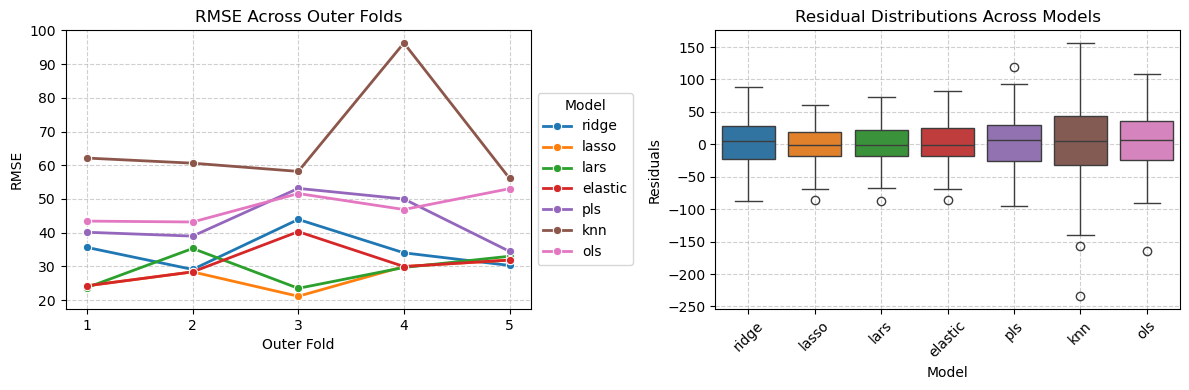

In [11]:
residuals_list = []

# Loop through each model and fold to extract the residuals
for model_name, folds in residuals.items():
    for fold_num, res in folds.items():
        # Convert the residuals to a DataFrame for the current fold and model
        residuals_list.append({
            "Model": model_name,
            "Fold": fold_num,
            "Residuals": res.values.flatten()  # Flatten the Series to get residual values as an array
        })
residuals_df = pd.DataFrame(residuals_list)
#residuals_df

# Melting the DataFrame for better format for seaborn (model and residuals in separate columns)
residuals_df = residuals_df.explode("Residuals").reset_index(drop=True)

# Convert model_r2_dict into a DataFrame
RMSE_df = pd.DataFrame(RMSE_final)
RMSE_df.index.name = "Fold"
RMSE_df = RMSE_df.reset_index()
RMSE_df = RMSE_df.melt(id_vars=["Fold"], var_name="Model", value_name="RMSE")

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Define a custom color palette (optional)
palette = sns.color_palette("tab10")

# Residuals boxplot
sns.boxplot(data=residuals_df, x="Model", y="Residuals", palette=palette, ax=axes[1])
axes[1].set_title("Residual Distributions Across Models")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Residuals")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# RMSE plot (Using r2_df since that's RMSE-based data)
sns.lineplot(data=RMSE_df, x="Fold", y="RMSE", hue="Model", marker="o", linewidth=2, palette=palette, ax=axes[0])
axes[0].set_title("RMSE Across Outer Folds")
axes[0].set_ylabel("RMSE")
axes[0].set_xlabel("Outer Fold")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(title="Model", bbox_to_anchor=(1, 0.8), loc="upper left")  # Keep legend in second plot
axes[0].set_xticks(range(RMSE_df["Fold"].min(), RMSE_df["Fold"].max() + 1, 1))  # Ensure x-axis increments by 1

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

# Lasso 1-std-error-rule

In [ ]:
# Define range of alphas
alphas = np.linspace(0, 5, 50)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=6)

# Store performance across folds
rmse_matrix = []
r2_matrix = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_train, X_test, y_train, y_test = handlingOfdata(X_train, X_test, y_train, y_test)

    fold_rmse = []
    fold_r2 = []
    for alpha in alphas:
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        fold_rmse.append(rmse)
        fold_r2.append(r2)

    rmse_matrix.append(fold_rmse)
    r2_matrix.append(fold_r2)

# Convert to array for easier manipulation
rmse_matrix = np.array(rmse_matrix)  # Shape: (n_outer_folds, n_alphas)
r2_matrix = np.array(r2_matrix)

# Compute mean and std RMSE for each alpha
mean_rmse_per_alpha = rmse_matrix.mean(axis=0)
std_rmse_per_alpha = rmse_matrix.std(axis=0)

mean_r2_per_alpha = r2_matrix.mean(axis=0)
std_r2_per_alpha = r2_matrix.std(axis=0)

# Best alpha = lowest mean RMSE
best_alpha_idx = np.argmin(mean_rmse_per_alpha)
best_alpha = alphas[best_alpha_idx]
best_rmse = mean_rmse_per_alpha[best_alpha_idx]
best_rmse_std = std_rmse_per_alpha[best_alpha_idx]

best_r2 = mean_r2_per_alpha[best_alpha_idx]
best_r2_std = std_r2_per_alpha[best_alpha_idx]

# 1-std rule: pick most regularized alpha within 1 std of best
candidate_indices = np.where(mean_rmse_per_alpha <= best_rmse + best_rmse_std)[0]
one_std_idx = candidate_indices[-1]
one_std_alpha = alphas[one_std_idx]
rmse_one_std = mean_rmse_per_alpha[one_std_idx]
r2_one_std = mean_r2_per_alpha[one_std_idx]

print(f"Best alpha: {best_alpha}")
print(f"Best RMSE: {best_rmse} ± {best_rmse_std}")
print(f"Best R²: {best_r2} ± {best_r2_std}\n")

print(f"1-std-rule alpha: {one_std_alpha}")
print(f"RMSE with 1-std-rule applied: {rmse_one_std}")
print(f"R² with 1-std-rule applied: {r2_one_std}")

Best alpha: 0.9183673469387755
Best RMSE: 25.357470613110287 ± 4.200534668379506
Best R²: 0.8588635651987546 ± 0.07346552997919827

1-std-rule alpha: 4.387755102040816
RMSE with 1-std-rule applied: 29.45562341152646
R² with 1-std-rule applied: 0.8127548551720472


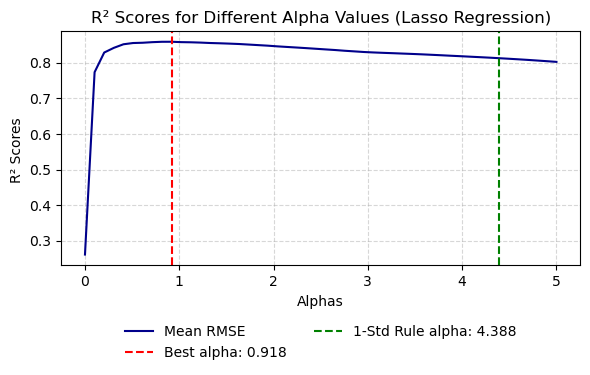

In [ ]:
# Plot RMSE vs Alpha
plt.figure(figsize=(6, 4))
plt.plot(alphas, mean_r2_per_alpha, label='Mean RMSE', color='darkblue')
#plt.fill_between(alphas,
#                 mean_r2_per_alpha - std_r2_per_alpha,
#                 mean_r2_per_alpha + std_r2_per_alpha,
#                 alpha=0.2, color='darkblue', label='±1 std dev')

# Mark best alpha (lowest mean RMSE)
plt.axvline(best_alpha, linestyle='--', color='red',
            label=f'Best alpha: {round(best_alpha, 3)}')

# Mark alpha from 1-standard-error rule
plt.axvline(one_std_alpha, linestyle='--', color='green',
            label=f'1-Std Rule alpha: {round(one_std_alpha, 3)}')

# Labels and formatting
plt.xlabel('Alphas')
plt.ylabel('R² Scores ')
plt.title('R² Scores for Different Alpha Values (Lasso Regression)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
lassoFinal = Lasso(alpha=one_std_alpha)
lassoFinal.fit(Xall, yall)
joblib.dump(lassoFinal, "LassoTrained_model.pkl")

['LassoTrained_model.pkl']

# Significance of the model perfromace?

In [ ]:
# Extract RMSE scores
rmse_df = pd.DataFrame(RMSE_final)  # RMSE values from cross-validation
#print(rmse_df)

# Define significance level
alpha = 0.05
lasso_model = "lasso"
other_models = [model for model in rmse_df.columns if model != lasso_model]

# Perform paired t-tests
p_values = []
t_stats = []
model_pairs = []

for model in other_models:
    t_stat, p_value = ttest_rel(rmse_df[lasso_model], rmse_df[model])  # Paired test
    t_stats.append(t_stat)
    p_values.append(p_value)
    model_pairs.append(model)

# Apply Bonferroni correction
_, p_adjusted, _, _ = multipletests(p_values, method='bonferroni', alpha=alpha)

# Store results in DataFrame
t_test_results = pd.DataFrame({
    "Lasso": lasso_model,
    "Compared Model": model_pairs,
    "T-Statistic": t_stats,
    "P-Value": p_values,
    "Adjusted P-Value": p_adjusted
})

# Add a column for "Difference Significant" based on the adjusted p-value
t_test_results["Difference Significant"] = t_test_results["Adjusted P-Value"].apply(lambda x: "Yes" if x < alpha else "No")

# Display results sorted by adjusted p-value
t_test_results = t_test_results.sort_values("Adjusted P-Value")
t_test_results

,Lasso,Compared Model,T-Statistic,P-Value,Adjusted P-Value,Difference Significant
5,lasso,ols,-7.565129,0.001637,0.009819,Yes
4,lasso,knn,-5.557206,0.005133,0.030796,Yes
3,lasso,pls,-3.307123,0.029734,0.178406,No
0,lasso,ridge,-1.694142,0.165487,0.992923,No
1,lasso,lars,-1.417894,0.229200,1.000000,No
2,lasso,elastic,-1.000000,0.373901,1.000000,No
